In [1]:
import torch
import HodgkinHuxley
import matplotlib.pyplot as plt
import numpy as np
import functions as func
import time

 
 << defining template for one-compartment sPY cell >> 
 
 
<< sPY: passive, INa, IK, IM inserted >>
 
	Vector[0] 


In [2]:
import sys
print("Python version")
print (sys.version)

print("Version info.")
print (sys.version_info)

Python version
3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
Version info.
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)


In [3]:
import os

print(os.getcwd())

seed_data = 7
nbr_params = 10

/home/samuel/Documents/projects/seq posterior approx w nf/seq posterior approx w nf dev/hodgkin_huxley


## Gen sbi data

In [4]:
model = HodgkinHuxley.HodgkinHuxley("snl", nbr_params)

In [5]:
t_vec = np.array(HodgkinHuxley.h.t_vec)

In [6]:
v_true, Iinj = model.simulator(model.log_theta_true, 7, True)


In [14]:
torch.manual_seed(1)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [16]:
v_true = model.simulator(model.log_theta_true, None)

print(v_true)


[-70.         -70.05725684 -70.05150955 ... -94.43337415 -94.41716511
 -94.29463555]


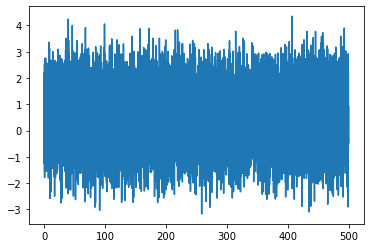

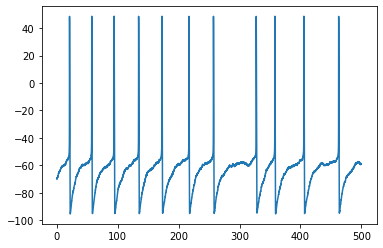

In [8]:
plt.figure()
plt.plot(t_vec, Iinj)

plt.figure()
plt.plot(t_vec, v_true)

In [9]:
v_true


array([-70.        , -69.81132618, -69.80886306, ..., -58.83794574,
       -58.92070564, -58.94490557])

In [12]:
v_true = model.simulator(model.log_theta_true)


In [13]:
v_true

array([-70.        , -69.81132618, -69.80886306, ..., -58.83794574,
       -58.92070564, -58.94490557])

In [14]:
summary_stats_obs = model.calculate_summary_statistics(v_true)


In [15]:
summary_stats_obs


array([ 1.10000000e+01, -6.39641207e+01,  2.69540787e+00,  2.82741764e+00,
        1.51725213e+02,  7.60601104e+03,  3.14930036e+00,  6.98166171e+00,
        1.09055392e+01,  1.75101668e-01,  6.31393418e-02, -7.76406284e-03,
       -5.40363342e-02, -8.43142793e-02, -1.00384131e-01, -1.09960906e-01,
       -1.08660758e-01, -9.89265218e-02, -9.03991759e-02])

#### set up model simulator

In [17]:
def simulator_wrapper(params):

  return model.calculate_summary_statistics(model.simulator(params))


In [18]:
# run pilot to calc mean and std of summary stats
means_w, U_w, istds_w = func.pilot_run(model, simulator_wrapper, summary_stats_obs)

Pilot run: running 5000 simulations: 100%|██████████| 5000/5000 [03:38<00:00, 22.93it/s]


In [19]:
summary_stats_obs_w = func.whiten(summary_stats_obs, (means_w, U_w, istds_w))


In [20]:
w_sim_wrapper = lambda param: torch.as_tensor(func.whiten(simulator_wrapper(param), (means_w, U_w, istds_w)))

#### run inference using SNPE

In [21]:
from sbi.inference import SNPE_C, prepare_for_sbi

simulator, prior = prepare_for_sbi(w_sim_wrapper, model.prior)

In [22]:
def build_custom_post_net(batch_theta, batch_x):

    flow_lik, flow_post = func.set_up_networks(model.prior.base_dist.low,
                                               model.prior.base_dist.high,
                                               dim_post = model.nbr_params)

    return flow_post

In [23]:
a = 1
b = 2

flow_post = build_custom_post_net(a,b)



tensor([-4.1918, -2.9299,  2.7268, -2.9299, -3.5609, -3.2362,  3.0515, -5.6568,
        -3.0959,  0.6309])
tensor([0.9102, 0.9102, 0.9102, 0.9102, 0.9102, 0.9102, 0.9102, 0.9102, 0.9102,
        0.9102])


In [24]:
s_temp = flow_post.sample(10)

In [25]:
s_temp


tensor([[ 4.6052,  3.5320, -2.8526,  3.3071,  3.9899,  4.5535, -2.2669,  7.3132,
          3.8428, -0.5493],
        [ 5.1979,  4.3168, -2.9957,  4.3174,  3.9121,  3.5747, -3.3506,  6.2181,
          4.1325, -0.6928],
        [ 4.6052,  4.3174, -1.8971,  4.2644,  4.4638,  4.2872, -2.2688,  6.4345,
          3.4526, -0.6039],
        [ 5.6352,  4.3171, -1.9050,  3.4856,  4.5584,  4.4729, -2.2570,  6.5584,
          3.4012, -0.0469],
        [ 5.7038,  4.3175, -1.8972,  4.0969,  4.4614,  4.6540, -3.3513,  6.2161,
          3.8422, -0.6931],
        [ 4.6134,  3.6098, -2.2109,  3.2190,  4.9700,  4.6533, -2.2575,  7.3132,
          3.4048,  0.3531],
        [ 4.6052,  4.1391, -1.9011,  3.2754,  4.8796,  4.3000, -3.1368,  6.9407,
          3.4020, -0.5771],
        [ 5.2546,  3.3203, -2.0589,  3.2365,  4.2363,  4.4129, -2.2551,  6.2505,
          3.4069,  0.0114],
        [ 5.4982,  4.1679, -2.0239,  3.2319,  4.1112,  4.3392, -2.2570,  7.1415,
          3.4537,  0.4051],
        [ 5.7038,  

In [26]:
s = torch.from_numpy(summary_stats_obs_w).to(dtype=torch.float32).reshape(1,19)
s_temp = flow_post.sample(10, context=s)


# why is this samping the same values???


In [27]:
s_temp

tensor([[[ 4.8291,  4.2685, -1.8971,  4.3168,  4.9964,  3.8682, -2.3843,
           6.2265,  4.4136, -0.4346],
         [ 5.7038,  4.3175, -2.5356,  3.8325,  3.9120,  3.5553, -3.3524,
           6.5173,  3.4017,  0.4055],
         [ 5.1766,  4.0033, -1.9384,  4.3175,  5.0100,  3.5558, -2.3264,
           6.2146,  4.4990,  0.0445],
         [ 4.6542,  3.8222, -2.0012,  3.2230,  5.0106,  4.6222, -2.2560,
           7.3132,  4.4991, -0.4106],
         [ 5.6623,  4.3175, -2.0568,  3.7864,  4.7619,  4.4591, -3.2891,
           7.2397,  3.4043, -0.5917],
         [ 5.7038,  4.3175, -2.5356,  3.8325,  3.9120,  3.5553, -3.3524,
           6.2227,  4.3227,  0.4055],
         [ 5.7038,  3.2189, -2.9293,  3.2189,  3.9174,  3.9908, -2.2542,
           7.3110,  4.4598,  0.2462],
         [ 5.4725,  4.0036, -2.9954,  3.7772,  5.0106,  3.5554, -3.3282,
           7.3130,  4.4841, -0.4864],
         [ 5.7038,  4.3175, -2.2218,  4.0238,  4.6796,  4.6540, -3.3504,
           7.3132,  4.2071, -0.6643],
 

In [28]:
print(summary_stats_obs)

print(summary_stats_obs_w)

[ 1.10000000e+01 -6.39641207e+01  2.69540787e+00  2.82741764e+00
  1.51725213e+02  7.60601104e+03  3.14930036e+00  6.98166171e+00
  1.09055392e+01  1.75101668e-01  6.31393418e-02 -7.76406284e-03
 -5.40363342e-02 -8.43142793e-02 -1.00384131e-01 -1.09960906e-01
 -1.08660758e-01 -9.89265218e-02 -9.03991759e-02]
[ 0.19886318  0.02722492  0.36288929  0.31121818  0.96236405  0.77310258
 -0.50050437  0.34081279 -0.54590754 -0.54535389  0.49589545  0.0246563
  0.35920431 -0.44890908  0.19271103  0.10890317  0.15748448  0.45983746
  0.20021979]


In [29]:
inference = SNPE_C(simulator, prior, density_estimator=build_custom_post_net)

In [30]:
start = time.time()

torch.manual_seed(1)
np.random.seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

num_rounds = 10
x_o = torch.from_numpy(summary_stats_obs_w).to(dtype=torch.float32).reshape(1,19)

posteriors = []
proposal = None

for i in range(num_rounds):
    #lr = 0.001*math.exp(-0.95 * i)
    posterior = inference(num_simulations=2000, proposal=proposal, max_num_epochs=200) #, learning_rate=1e-3)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)


end = time.time()
run_time = end - start

print("")
print("Runtime:" + str(round(run_time, 2)))


tensor([-4.1918, -2.9299,  2.7268, -2.9299, -3.5609, -3.2362,  3.0515, -5.6568,
        -3.0959,  0.6309])
tensor([0.9102, 0.9102, 0.9102, 0.9102, 0.9102, 0.9102, 0.9102, 0.9102, 0.9102,
        0.9102])
Neural network successfully converged after 60 epochs.
Using SNPE-C with atomic loss


Neural network successfully converged after 63 epochs.
Using SNPE-C with atomic loss


Neural network successfully converged after 62 epochs.
Using SNPE-C with atomic loss


Neural network successfully converged after 61 epochs.
Using SNPE-C with atomic loss


Neural network successfully converged after 29 epochs.
Using SNPE-C with atomic loss


Neural network successfully converged after 24 epochs.
Using SNPE-C with atomic loss


Neural network successfully converged after 25 epochs.
Using SNPE-C with atomic loss


Neural network successfully converged after 33 epochs.
Using SNPE-C with atomic loss


Neural network successfully converged after 33 epochs.
Using SNPE-C with atomic loss


Neural netwo

In [31]:
prior_limits = []

for i in range(model.nbr_params):
    prior_limits.append([round(model.prior.base_dist.low[i].item(),1),
                         round(model.prior.base_dist.high[i].item(),1)])


In [32]:

if model.nbr_params == 12:

    labels = ["log(gbar_Na)",
              "log(gbar_K)",
              "log(g_leak)",
              "log(E_Na)",
              "log(-E_K)",
              "log(-E_leak)",
              "log(gbar_M)",
              "log(tau_max)",
              "log(kappa_beta_n_1)",
              "log(kappa_beta_n_2)",
              "log(Vt)",
               "log(sigma)"]

elif model.nbr_params == 10:

    labels = ["log(gbar_Na)",
              "log(gbar_K)",
              "log(g_leak)",
              "log(E_Na)",
              "log(-E_K)",
              "log(-E_leak)",
              "log(gbar_M)",
              "log(tau_max)",
              "log(Vt)",
               "log(sigma)"]


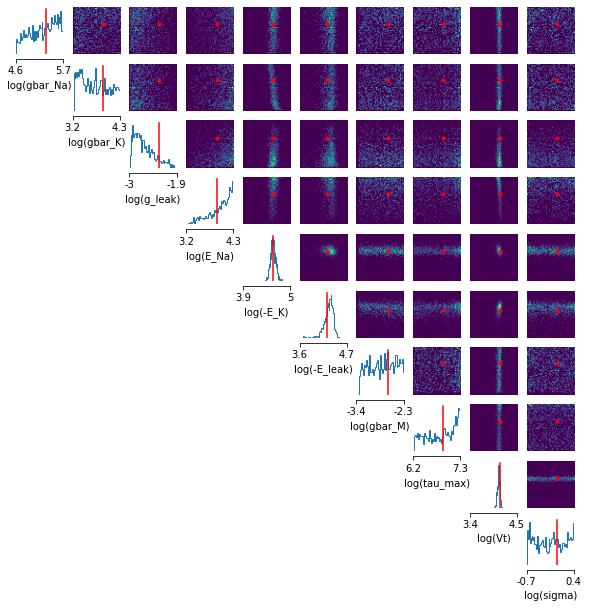

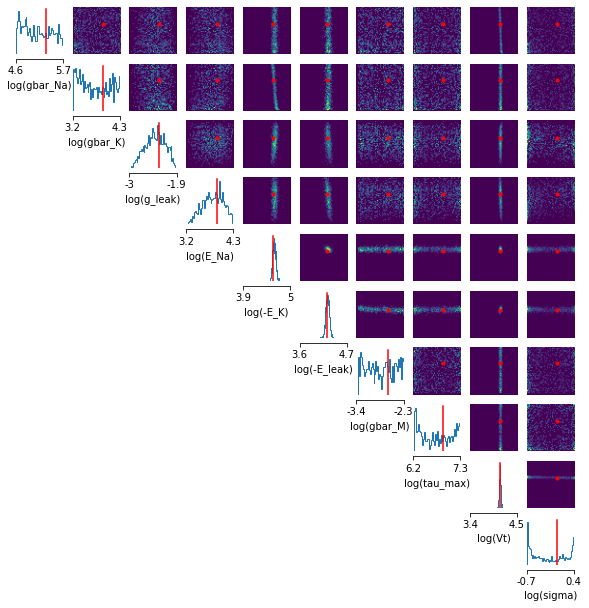

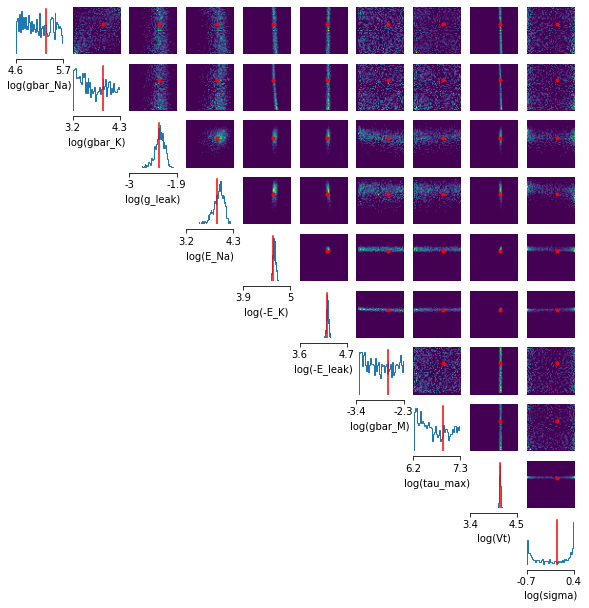

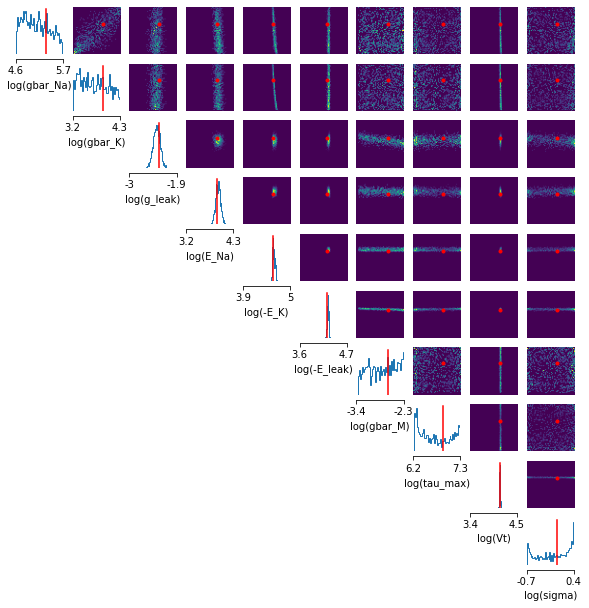

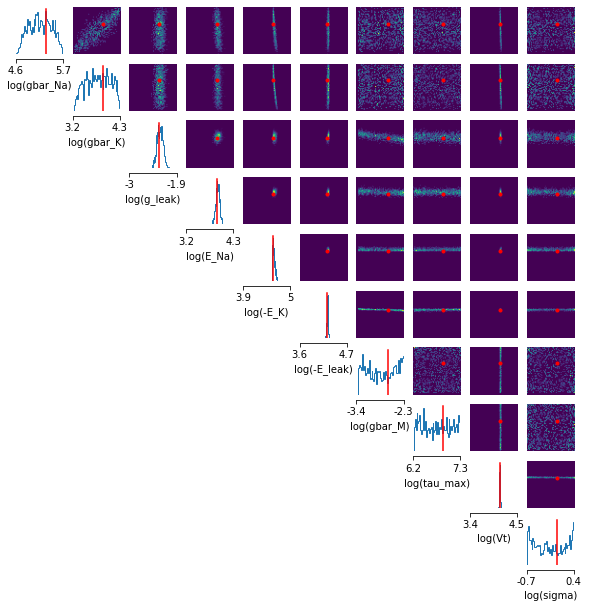

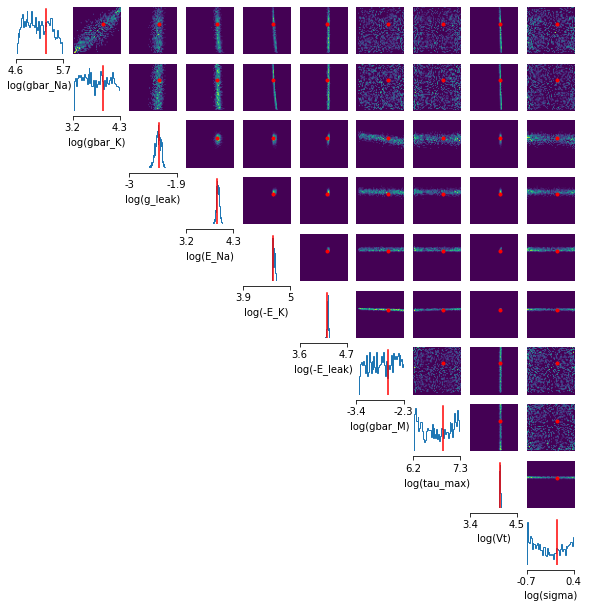

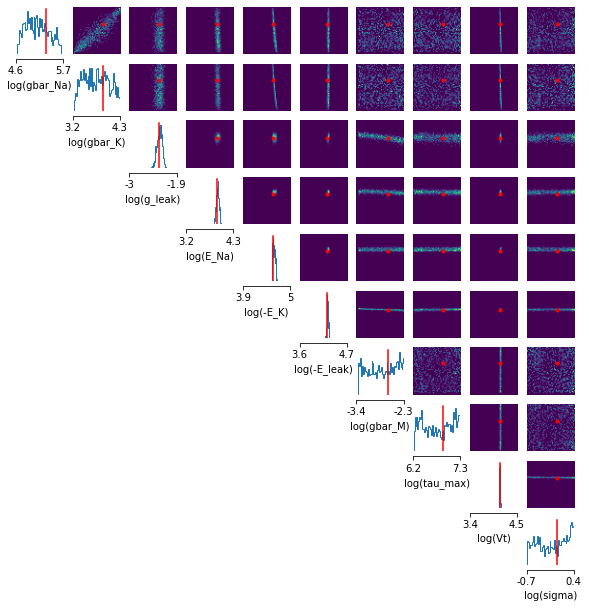

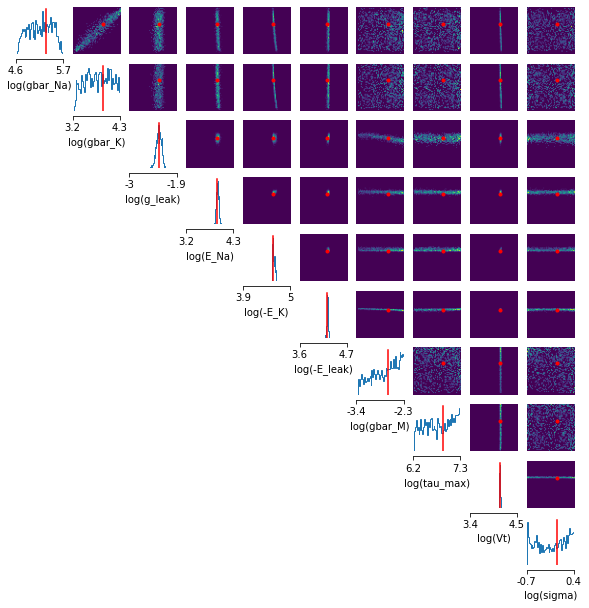

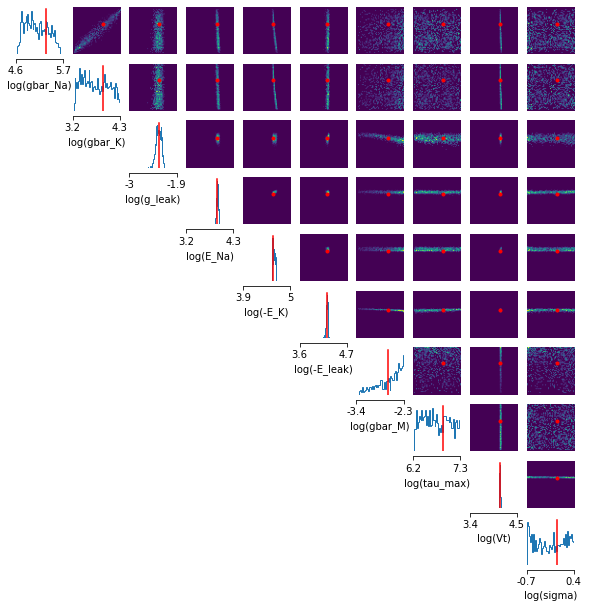

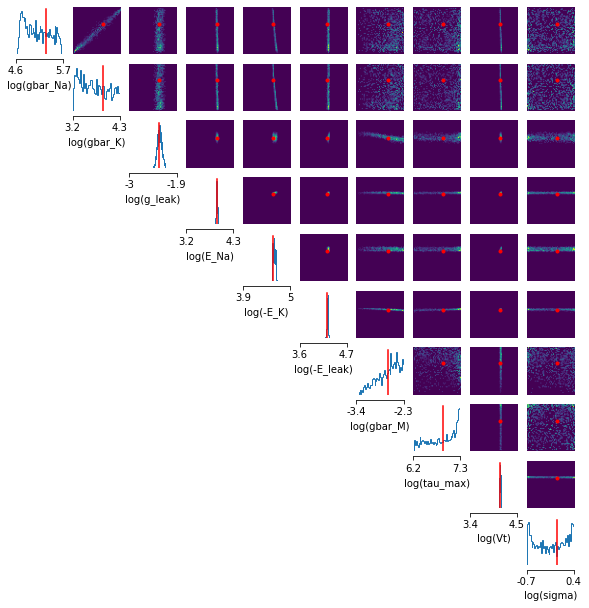

In [33]:
from sbi import utils as utils

for p in posteriors:
    samples = p.sample((1000,), x=x_o)

    fig, axes = utils.pairplot(samples,
                               points=torch.as_tensor(model.log_theta_true),
                               points_offdiag={'markersize': 6},
                               points_colors='r',
                               limits=prior_limits,
                               ticks=prior_limits,
                               labels = labels)


In [36]:
model.case


'snl'

In [ ]:
samples1 = posteriors[0].sample((1000,), x=x_o)
samples2 = posteriors[1].sample((1000,), x=x_o)
samples3 = posteriors[2].sample((1000,), x=x_o)
samples4 = posteriors[3].sample((1000,), x=x_o)
samples5 = posteriors[4].sample((1000,), x=x_o)



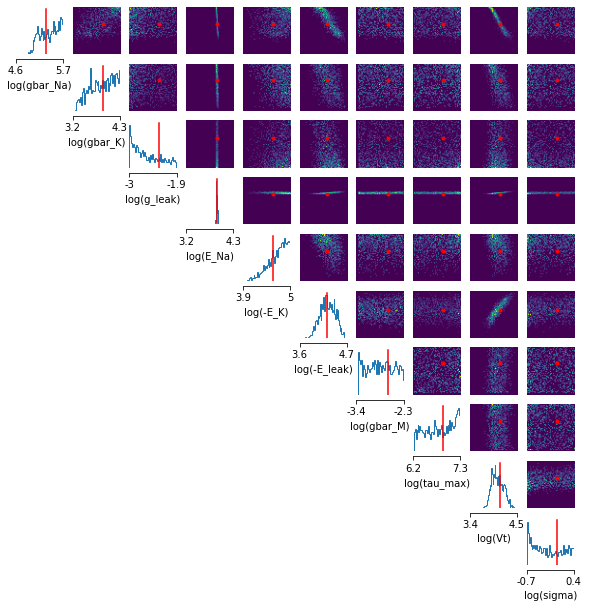

In [29]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples2,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)


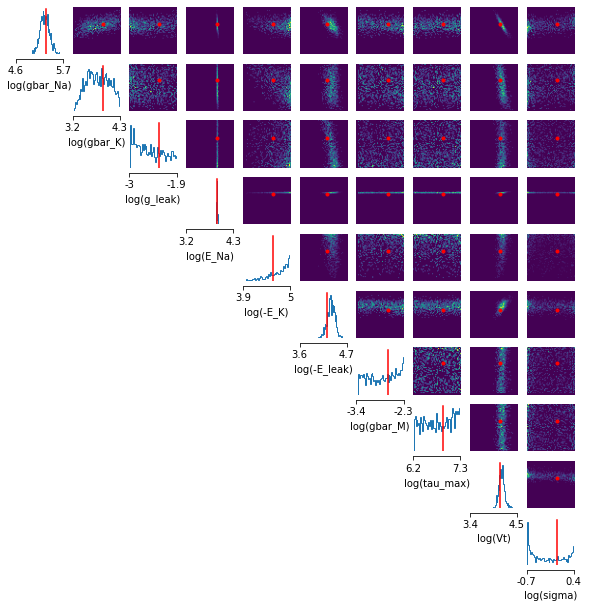

In [30]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples3,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)

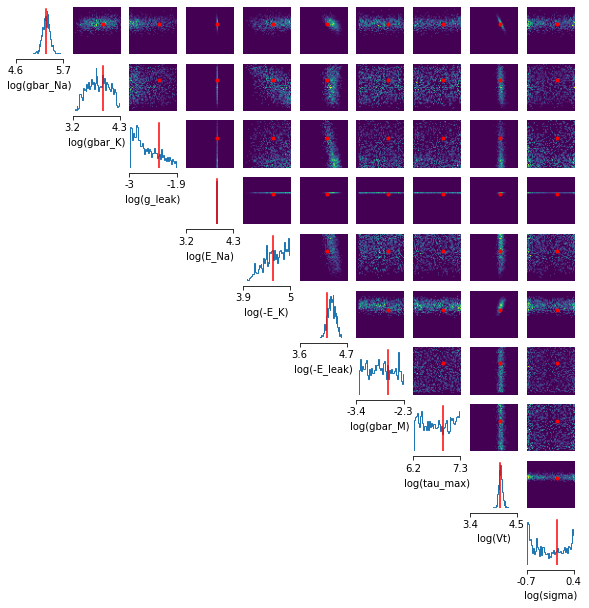

In [31]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples4,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)

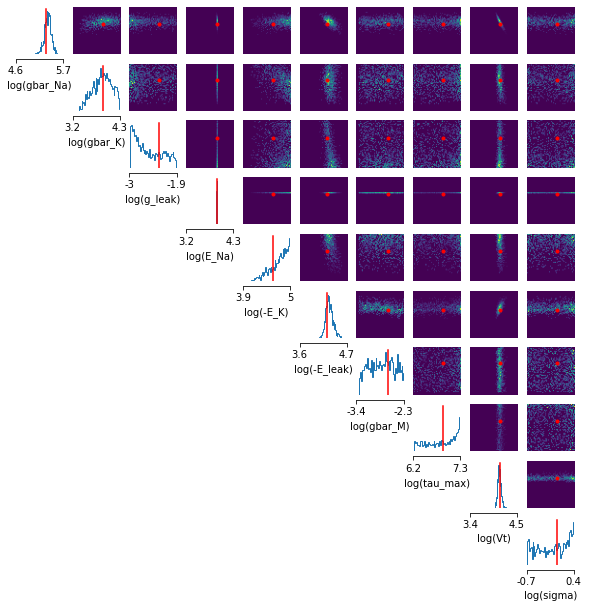

In [32]:
from sbi import utils as utils
fig, axes = utils.pairplot(samples5,
                           points=torch.as_tensor(model.log_theta_true),
                           points_offdiag={'markersize': 6},
                           points_colors='r',
                           limits=prior_limits,
                           ticks=prior_limits,
                           labels = labels)

In [ ]:
sample_np = samples.numpy()

In [ ]:
for i in range(10):
    plt.figure()
    plt.hist(sample_np[:,i])
    plt.plot(model.log_theta_true[i], 2, "*")
    print(model.prior.base_dist.low[i])
    print(model.prior.base_dist.high[i])

In [ ]:
v = sim_obs["data"]

In [ ]:
ind = np.where(v < -10)
v[ind] = -10
ind = np.where(np.diff(v) < 0)
v[ind] = -10


In [ ]:
auto_corrs = torch.zeros(10)
nbr_samples = v.shape[0]
v_tensor = torch.as_tensor(v)


In [ ]:
lag = 250
auto_corrs[0] = torch.dot(v_tensor[lag:], v_tensor[:-lag]) / (nbr_samples - 1)


In [ ]:
auto_corrs



## Lueckmann17

#### sim data from gt parameters

In [ ]:
t = np.loadtxt('data/t_Lueckmann17.csv', delimiter=",")
i = np.loadtxt('data/i_Lueckmann17.csv', delimiter=",")
v = np.loadtxt('data/v_Lueckmann17.csv', delimiter=",")

A_soma = np.pi * ((70.0 * 1e-4) ** 2)  # cm2


In [ ]:
model_Lueckmann17 = HodgkinHuxley.HodgkinHuxley("Lueckmann17")

In [ ]:

plt.figure()
plt.plot(t, i)


plt.figure()
plt.plot(t, i*0.001/A_soma)

In [ ]:
def run_model_Lueckmann17(params):

    A_soma = np.pi * ((70.0 * 1e-4) ** 2)  # cm2

    i_input = i*0.001/A_soma # muA/cm2

    # initial voltage
    V0 = -70

    states = model.simulator(V0, params.reshape(1, -1), model_Lueckmann17.dt, t, i_input)

    return dict(data=states.reshape(-1), time=t, dt=model_Lueckmann17.dt, I=i_input)


In [ ]:
param_input = model_Lueckmann17.log_theta_true

sim_res = run_model_Lueckmann17(np.asarray(param_input))

In [ ]:
# plot simulated model
import matplotlib.pyplot as plt

plt.figure()
plt.plot(sim_res["time"], sim_res["I"])


plt.figure()
plt.plot(sim_res["time"], sim_res["I"]*A_soma*1e3)

plt.figure()
plt.plot(sim_res["time"], sim_res["data"])


#### calc summary stats for data

#### set up model simulator


#### run inference using SNPE-C